# Lab Session 2
# Generative Adversarial Networks (GANs)

In this lab session, we will explore **generative models** and in particular, we will build a Generative Adversarial Network. GANs are basically neural networks that learn to generate samples (synthetic data) that are very similar to some input data. In this exercise, we build and train a simple GAN that can generate new images (handwritten digits) that resemble a set of training images (taken from MNIST dataset). In a way, we are teaching a neural network how to write.

### Recap on GANs

GANs consist of two different neural networks (models). 
The first network is called the **discriminator** and is a standard binary classifier that determines whether an image looks like a real one (taken from the dataset) or a fake one (not present in the training set). 
The second network is called the **generator**. It takes random noise as input and transforms it into images using a neural network. The goal of the generator is to fool the discriminator into thinking the images it produced are real.

The continuous process of the generator ($G$) trying to fool the discriminator ($D$), and the discriminator trying to correctly classify real vs. fake can be described as a minimax game:
$$\underset{G}{\text{min}}\; \underset{D}{\text{max}}\; \mathbb{E}_{x \sim p_\text{data}}\left[\log D(x)\right] + \mathbb{E}_{z \sim p(z)}\left[\log \left(1-D(G(z))\right)\right]$$
where $x \sim p_\text{data}$ are samples from the input data, $z \sim p(z)$ are the random noise samples, $G(z)$ are the generated images using the neural network generator $G$, and $D$ is the output of the discriminator, specifying the probability of an input being real. This minimax game is shown to be related to minimizing the Jensen-Shannon divergence between the training data distribution and the generated samples from $G$.

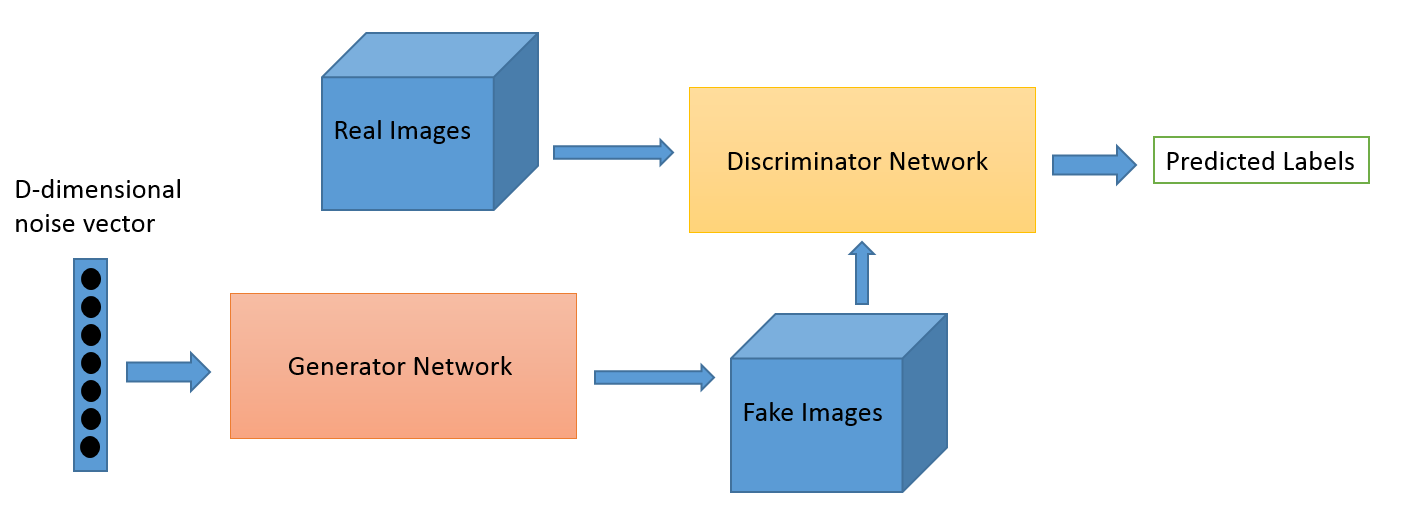

To optimize this minimax game, we alternate between taking gradient descent steps on the objective for $G$, and gradient ascent steps on the objective for $D$:
1. update $G$ to minimize the probability of the __discriminator making the correct choice__. 
2. update $D$ to maximize the probability of the __discriminator making the correct choice__.

As we discussed during the lecture, we update the generator as maximizing the probability of the **discriminator making the incorrect choice**. That way, we alleviate the vanishing gradient problem of the generator. Therefore, in this exercise, we alternate the following updates:
1. Update $G$ to maximize the probability of the discriminator making the incorrect choice on generated data:
$$\underset{G}{\text{max}}\;  \mathbb{E}_{z \sim p(z)}\left[\log D(G(z))\right]$$
2. Update $D$, to maximize the probability of the discriminator making the correct choice on real and generated data:
$$\underset{D}{\text{max}}\; \mathbb{E}_{x \sim p_\text{data}}\left[\log D(x)\right] + \mathbb{E}_{z \sim p(z)}\left[\log \left(1-D(G(z))\right)\right]$$


### Lab Session Objective and Output: 
You will need to complete the notebooks by performing all tasks (7 implementation tasks and 2 questions related to a qualitative assessment of your results).

## Initial Setup and Imports

In [ ]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
#Tensorflow is imported as tf using that way to avoid any compability issues between TF versions

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) 
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'inferno'

# Functions for plotting and training
def show_images(images):
    images = np.reshape(images, [images.shape[0], -1])
    sqrtn = int(np.ceil(np.sqrt(images.shape[0])))
    sqrtimg = int(np.ceil(np.sqrt(images.shape[1])))

    fig = plt.figure(figsize=(sqrtn, sqrtn))
    gs = gridspec.GridSpec(sqrtn, sqrtn)
    gs.update(wspace=0.05, hspace=0.05)

    for i, img in enumerate(images):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(img.reshape([sqrtimg,sqrtimg]))
    return

def img_show():
    config = tf.ConfigProto()
    show = tf.Session(config=config)
    return show


## Loading Dataset (MNIST data)
For simplicity and computational convenience, we use the MNIST dataset. This dataset contains real handwritten digits and 70,000 images of handwritten digits compiled by the U.S. National Institute of Standards and Technology from Census Bureau employees and high school students. Each picture contains a centered image of white digit on black background (0 through 9). 

In [ ]:
class MNIST(object):
    def __init__(self, batch_size, shuffle=False):
        """
        Inputs:
        - batch_size: Integer giving number of elements per minibatch
        - shuffle: (optional) Boolean, whether to shuffle the data on each epoch
        """
        train, _ = tf.keras.datasets.mnist.load_data()
        X, y = train
        X = X.astype(np.float32)/255
        X = X.reshape((X.shape[0], -1))
        self.X, self.y = X, y
        self.batch_size, self.shuffle = batch_size, shuffle

    def __iter__(self):
        N, B = self.X.shape[0], self.batch_size
        idxs = np.arange(N)
        if self.shuffle:
            np.random.shuffle(idxs)
        return iter((self.X[i:i+B], self.y[i:i+B]) for i in range(0, N, B)) 

# show a batch
mnist = MNIST(batch_size=16) 
show_images(mnist.X[:16])

## Activation Function
We implement below the neural network function. To avoid potential issues from ReLU, we will implement Leaky ReLU.

In [ ]:
def leaky_relu(x, alpha=0.01):
    """Compute the leaky ReLU activation function.
    Inputs:
    - x: TensorFlow Tensor with arbitrary shape
    - alpha: leak parameter for leaky ReLU
    Output:
    - y: a TensorFlow Tensor with the same shape as x
    """
    # TASK 1 TODO: Implement a leaky ReLU activation function
    # Your code here
    return y

## Random Noise
In the cell below, we will generate a random uniform noise from -1 to 1 with shape `[batch_size, dim]`.

In [ ]:
def random_noise(batch_size, dim):
    """
    Inputs:
    - batch_size: integer giving the batch size of noise to generate
    - dim: integer giving the dimension of the the noise to generate
    Output:
    - noise: a TensorFlow Tensor containing uniform noise in [-1, 1] with shape [batch_size, dim]
    """
    # Task 2 TODO: sample from and return random noise (uniform)
    # Your code here
    return noise

## Discriminator
First, we will implement the first neural network, the discriminator. To build the model, we will use the layers in `tf.layers`. The architecture we adopt is as follows:
 * Fully connected layer from size 784 to 256
 * LeakyReLU with alpha 0.01
 * Fully connected layer from 256 to 256
 * LeakyReLU with alpha 0.01
 * Fully connected layer from 256 to 1
 
The output of the discriminator should have shape `[batch_size, 1]`, and should contain real numbers corresponding to the scores that each of the `batch_size` inputs is a real image.

In [ ]:
def discriminator(x):
    """Compute discriminator score for a batch of input images.
    Input:
    - x: TensorFlow Tensor of flattened input images, shape [batch_size, 784]
    Output:
    - logits: a TensorFlow Tensor with shape [batch_size, 1], containing the score 
    for an image being real for each input image.
    """
    with tf.variable_scope("discriminator"):
        # Task 3 TODO: implement the discriminator NN architecture as described above
        # Your code here
    return logits

## Generator
Second, we will build the generator in a similar way as the discriminator. The architecure we adopt is:
 * Fully connected layer from tf.shape(z)[1] (the number of noise dimensions) to 1024
 * ReLU
 * Fully connected layer from 1024 to 1024 
 * ReLU
 * Fully connected layer from 1024 to 784
 * Tanh 

In [ ]:
def generator(z):
    """Generate images from a random noise vector.
    Input:
    - z: TensorFlow Tensor of random noise with shape [batch_size, noise_dim]
    Output:
    - img: a TensorFlow Tensor of generated images, with shape [batch_size, 784].
    """
    with tf.variable_scope("generator"):
        # Task 4 TODO: implement the generator NN architecture as described above
        # Your code here
        
    return img

# GAN Loss

We will implement below the loss of the GAN. 

The generator loss is:

$$\mathcal{L}_G  =  -\mathbb{E}_{z \sim p(z)}\left[\log D(G(z))\right]$$

The discriminator loss is:

$$\mathcal{L}_D = -\mathbb{E}_{x \sim p_\text{data}}\left[\log D(x)\right] - \mathbb{E}_{z \sim p(z)}\left[\log \left(1-D(G(z))\right)\right]$$

For computing the loss function, we will use the sigmoid cross entropy loss.

In [ ]:
def gan_loss(logits_real, logits_fake):
    """
    Inputs:
    - logits_real: Tensor, shape [batch_size, 1], output of discriminator
        Log probability that the image is real for each real image
    - logits_fake: Tensor, shape[batch_size, 1], output of discriminator
        Log probability that the image is real for each fake image
    
    Outputs:
    - D_loss: discriminator loss [scalar]
    - G_loss: generator loss [scalar]
    """
    # Task 5 TODO: Compute the loss functions: D_loss and G_loss
    # Your code here
    
    return D_loss, G_loss

# Optimizer
For the loss optimization, we will implement an `AdamOptimizer` with a 1e-3 learning rate, beta1=0.5 to mininize G_loss and D_loss separately. If you want to see a 'pathological' mode in GANs, you can beta1=0.9. That way, the discriminator loss might go to zero (i.e., learns too fast) and the generator might fail completely to learn. 
You can also experiment with other optimizers (e.g., SGD with Momentum or RMSProp). 

In [ ]:
# Task 6 TODO: Implement an AdamOptimizer for D_opt and G_opt
def gan_optimizers(learning_rate=1e-3, beta1=0.5):
    """Create optimizers for GAN training.
    Inputs:
    - learning_rate: learning rate to use for both optimizers
    - beta1: beta parameter for both optimizers (first moment decay)
    
    Outputs:
    - D_opt: instance of tf.train.AdamOptimizer with correct learning_rate and beta1
    - G_opt: instance of tf.train.AdamOptimizer with correct learning_rate and beta1
    """
    #Your code here

    return D_opt, G_opt

## GAN Composition
In the below cell, we compose the generator and discriminator by using the previous functions

In [ ]:
tf.reset_default_graph()

# number of images for each batch
batch_size = 128
# random noise dimension
noise_dim = 96

# placeholder for images from the training dataset
x = tf.placeholder(tf.float32, [None, 784])
# random noise fed into our generator
z = random_noise(batch_size, noise_dim)
# generated images
G_sample = generator(z)

with tf.variable_scope("") as scope:
    #scale images to be -1 to 1
    logits_real = discriminator(2 * x - 1.0)
    # Re-use discriminator weights on new inputs
    scope.reuse_variables()
    logits_fake = discriminator(G_sample)

# Get the list of variables for the discriminator and generator
D_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'discriminator')
G_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'generator') 

# get our solver
D_opt, G_opt = gan_optimizers()

# get our loss
D_loss, G_loss = gan_loss(logits_real, logits_fake)

# setup training steps
D_train_step = D_opt.minimize(D_loss, var_list=D_vars)
G_train_step = G_opt.minimize(G_loss, var_list=G_vars)
D_extra_step = tf.get_collection(tf.GraphKeys.UPDATE_OPS, 'discriminator')
G_extra_step = tf.get_collection(tf.GraphKeys.UPDATE_OPS, 'generator')

# Time to train our GAN!
It is not time to start training our GAN. We use a simple procedure. We train D(x) and G(z) with one batch each every iteration. Training could take several minutes if run on a CPU.

In [ ]:
# the main function to train a GAN

def run_a_gan(sess, G_train_step, G_loss, D_train_step, D_loss, G_extra_step, D_extra_step,
              show_every=2, print_every=1, batch_size=128, num_epoch=10):
    """Train a GAN for a certain number of epochs.
    Inputs:
    - sess: A tf.Session that we want to use to run our data
    - G_train_step: A training step for the Generator
    - G_loss: Generator loss
    - D_train_step: A training step for the Generator
    - D_loss: Discriminator loss
    - G_extra_step: A collection of tf.GraphKeys.UPDATE_OPS for generator
    - D_extra_step: A collection of tf.GraphKeys.UPDATE_OPS for discriminator
    """
    # compute the number of iterations needed
    mnist = MNIST(batch_size=batch_size, shuffle=True)
    for epoch in range(num_epoch):
        # show a sample result
        if epoch % show_every == 0:
            samples = sess.run(G_sample)
            fig = show_images(samples[:16])
            plt.show()
            print()
        for (minibatch, minbatch_y) in mnist:
            # run a batch of data through the network
            _, D_loss_curr = sess.run(
                [D_train_step, D_loss], feed_dict={x: minibatch})
            _, G_loss_curr = sess.run([G_train_step, G_loss])

        # We want to make sure D_loss doesn't go to 0
        if epoch % print_every == 0:
            print('Epoch: {}, D: {:.4}, G:{:.4}'.format(
                epoch, D_loss_curr, G_loss_curr))
    print('Final images')
    samples = sess.run(G_sample)

    fig = show_images(samples[:16])
    plt.show()

In [ ]:
with img_show() as sess:
    sess.run(tf.global_variables_initializer())
    run_a_gan(sess, G_train_step, G_loss, D_train_step,
              D_loss, G_extra_step, D_extra_step)

# GAN2: Changing the loss function and the divergence 
We will now implement a GAN with a different loss function. Specifically, we will implement the following objective functions for 
the generator loss:
$$\mathcal{L}_G  =  \frac{1}{2}\mathbb{E}_{z \sim p(z)}\left[\left(D(G(z))-1\right)^2\right]$$
and the discriminator loss:
$$ \mathcal{L}_D = \frac{1}{2}\mathbb{E}_{x \sim p_\text{data}}\left[\left(D(x)-1\right)^2\right] + \frac{1}{2}\mathbb{E}_{z \sim p(z)}\left[ \left(D(G(z))\right)^2\right]$$
This GAN variant is known as Least Squares GAN, which substitutes the binary cross entropy loss with a least square ($\ell_2$) loss, which has better properties for optimization and is less likely to saturate. It has been shown that minimizing the above objective functions yields minimizing the Pearson $\chi^2$ divergence.

In [ ]:
def gan2_loss(score_real, score_fake):
    """
    Inputs:
    - score_real: Tensor, shape [batch_size, 1], output of discriminator
        score for each real image
    - score_fake: Tensor, shape[batch_size, 1], output of discriminator
        score for each fake image    
    
    Outputs:
    - D_loss: discriminator loss scalar
    - G_loss: generator loss scalar
    """
    # Task 7 TODO: Compute the loss function D_loss and G_loss for the second GAN architecture
    # Your code here
    
    return D_loss, G_loss

Create new training steps to minimize the new GAN loss:

In [ ]:
D_loss, G_loss = gan2_loss(logits_real, logits_fake)
D_train_step = D_opt.minimize(D_loss, var_list=D_vars)
G_train_step = G_opt.minimize(G_loss, var_list=G_vars)

Run the below cell to train the model:

In [ ]:
with img_show() as ses:
    ses.run(tf.global_variables_initializer())
    run_a_gan(ses, G_train_step, G_loss, D_train_step, D_loss, G_extra_step, D_extra_step)

# Qualitative Results:
Task 8 TODO: Please comment on the visual quality of the samples and how the results change over different training runs.

Task 9 TODO: Re-train the first GAN architecture with random Gaussian noise instead of uniform. Please comment on the performance of the GAN and on the visual quality of the samples (during the course of the training).